In [9]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0) # Seed 고정

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def mae(y, pred):
    return np.mean(abs(y-pred))
 #점수 측정을 위한 코드  
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def validate(valid_x, valid_y, model):
    pred = model.predict(valid_x)
    smape_score, mae_score = SMAPE(valid_y, pred), mae(valid_y, pred)
    return smape_score, mae_score

In [10]:
for n_estimator in [40,45,50,55]:
    smape_scores = []
    mae_scores = []
    for i in range(1,101,1):
        train_df = pd.read_csv(f'./pretest/train_building{i}.csv')
        pretest_df = pd.read_csv(f'./pretest/pretest_building{i}.csv')
        x_train = train_df.drop(columns=['power_consumption'])
        y_train = train_df['power_consumption']
        y_valid = pretest_df['power_consumption']
        x_valid = pretest_df.drop(columns=['power_consumption'])
        
        #print(f"building_{i}")
        model_lgb1 = lgb.LGBMRegressor(objective='regression',
                                    n_estimators= n_estimator,
                                    verbose=-1)
        model_lgb1.fit(x_train, y_train)
        smape_score, mae_score = validate(x_valid, y_valid, model_lgb1)
        smape_scores.append(smape_score)
        mae_scores.append(mae_score)
    smape_mean = np.mean(smape_scores)
    mae_mean = np.mean(mae_scores)
        
    print(f"n_estimator: {n_estimator}")
    print(f'SMAPE: {smape_mean}\nMAE: {mae_mean}')

n_estimator: 40
SMAPE: 5.546098741038574
MAE: 108.85406975994275
n_estimator: 45
SMAPE: 5.541577310980853
MAE: 108.81752710294903
n_estimator: 50
SMAPE: 5.549662179584789
MAE: 109.02344153796813
n_estimator: 55
SMAPE: 5.577048335338086
MAE: 109.4621908946252


n_estimators= 45 최적

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


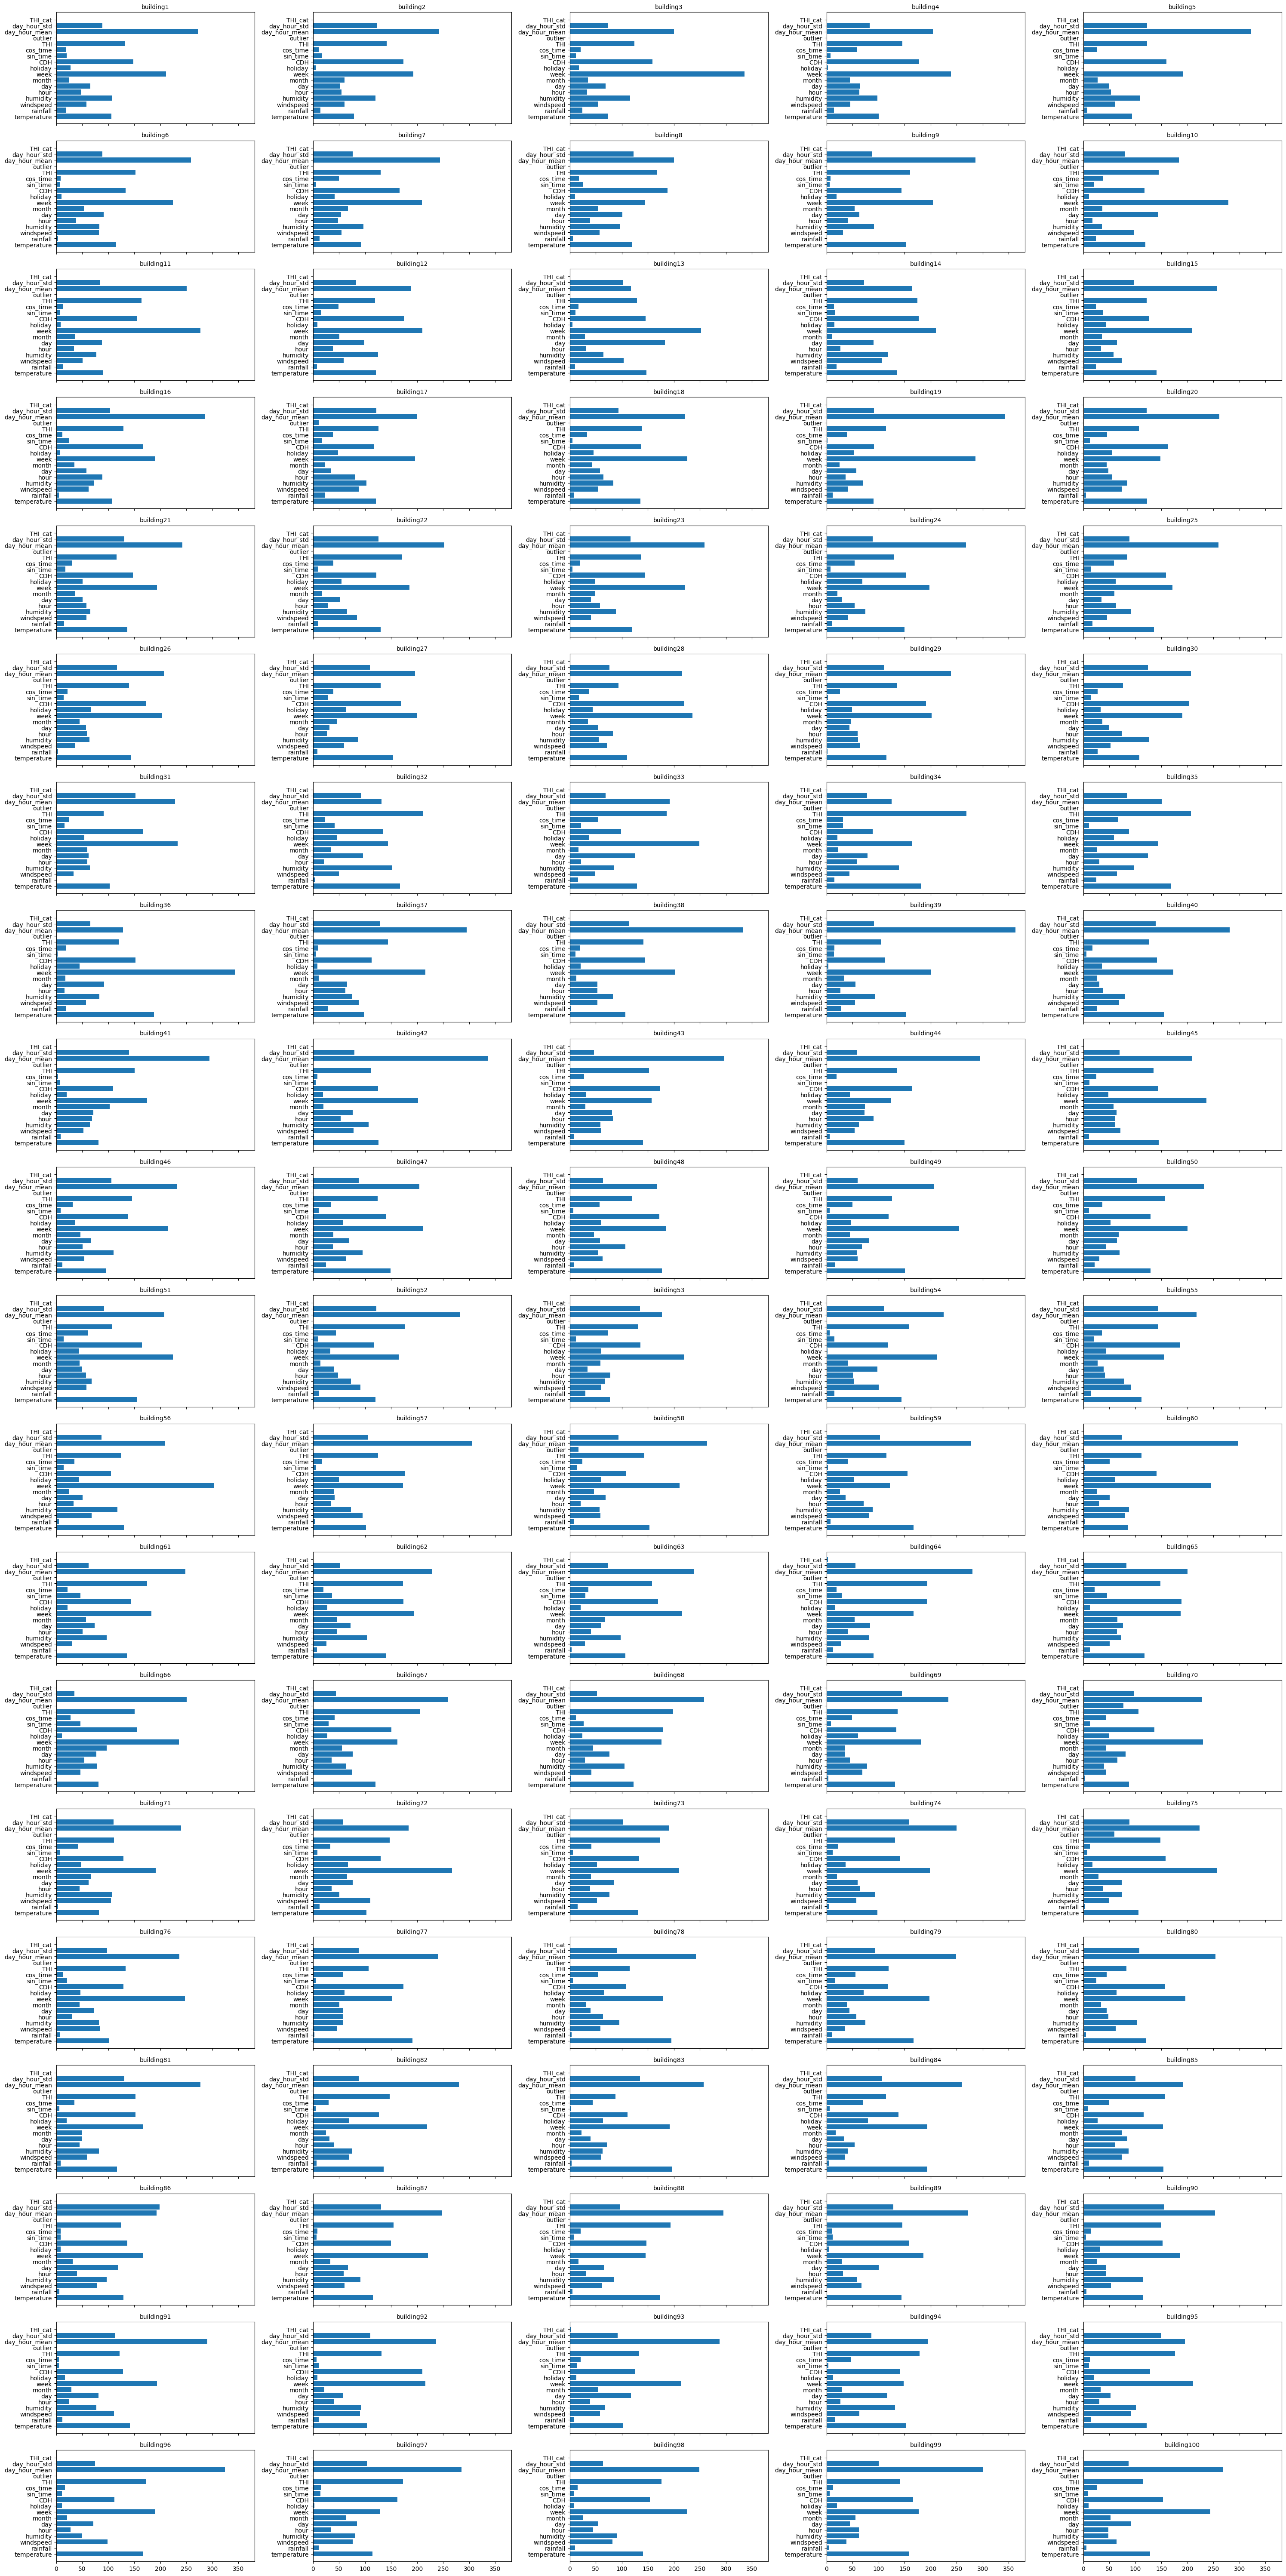

In [11]:
preds = np.array([])
fig, ax = plt.subplots(20, 5, figsize=(30, 60), sharex=True)
ax = ax.flatten()
for i in tqdm(range(1,101,1)):
    feature_importances = []
    train_df = pd.read_csv(f'./submit/train_building{i}.csv')
    test_df = pd.read_csv(f'./submit/test_building{i}.csv')
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    t_x = train_df.drop(columns=['power_consumption'])
    t_y = train_df['power_consumption']
 
    #print(f"building_{i}")
    for seed in [0,1,2,3,4,5,6]:
        
        model = lgb.LGBMRegressor(objective='regression',
                                    n_estimators= 45,
                                    verbose=-1,seed = seed)
        model.fit(t_x, t_y)
        y_pred = model.predict(test_df)
        feature_importances.append(model.feature_importances_)
        pred_df.loc[:,seed] = y_pred  
    pred = pred_df.mean(axis=1)
    preds = np.append(preds, pred)
    average_feature_importances = np.mean(feature_importances, axis=0)
    ax[i-1].set_title(f'building{i}',fontsize = 10)
    ax[i-1].barh(x_train.columns, average_feature_importances)
    
    

plt.tight_layout()
plt.show()
    


In [12]:
########################################
csv_name = './submission/lightGBM_wsw_seed_ensemble_nomalize.csv'
########################################

In [13]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = preds
submission.to_csv(f'{csv_name}', index = False)